In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from io import StringIO
import datetime
import operator

In [2]:
power = glob.glob('windpower/*.csv')
wind = glob.glob('wind/*.csv')
capacity = glob.glob('windcapacity/*.csv')

powerframes = []
windframes = []
capacityframes = []

for path in power:
    df = pd.read_csv(path)
    df.drop(columns=df.columns[[1, 2, 3]], inplace=True)
    df.columns = ['date', 'wind_power']
    df['date'] = pd.to_datetime(df['date']) 
    df.set_index(df.columns[0], inplace=True)
    powerframes.append(df)

for path in wind:
    df = pd.read_csv(path, parse_dates=True)
    df.columns = ['year', 'month', 'day', 'time', 'timezone', 'wind_speed']
    df['time'] = [x + ':00' for x in df['time']]
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + pd.to_timedelta(df['time'])
    df.drop(columns=df.columns[[0, 1, 2, 3, 4]], inplace=True)
    df.set_index('date',  inplace=True)
    windframes.append(df)

for path in capacity:
    df = pd.read_csv(path)
    df.drop(columns=df.columns[[1, 2, 3]], inplace=True)
    df.columns = ['date', 'wind_capacity']
    df['date'] = pd.to_datetime(df['date']) 
    df.set_index(df.columns[0], inplace=True)
    capacityframes.append(df)

power = pd.concat(powerframes).resample('10Min').mean()
wind = pd.concat(windframes).resample('10Min').mean()
capacity = pd.concat(capacityframes).resample('10Min').ffill()
print(len(power), len(wind), len(capacity))
data = power.join(wind, how='right').join(capacity, how='right')
print("Nans:", data.isna().sum())
data = data.dropna()
print(data)

52560 61201 52699
Nans: wind_power       156
wind_speed         5
wind_capacity      0
dtype: int64
                      wind_power  wind_speed  wind_capacity
date                                                       
2021-02-28 21:00:00  2139.000000         3.7         2442.0
2021-02-28 21:10:00  2133.825000         3.8         2442.0
2021-02-28 21:20:00  2148.833333         4.1         2442.0
2021-02-28 21:30:00  2162.000000         4.0         2442.0
2021-02-28 21:40:00  2184.375000         3.7         2442.0
...                          ...         ...            ...
2022-02-28 20:10:00  2659.625000         3.9         3506.0
2022-02-28 20:20:00  2655.166667         3.8         3506.0
2022-02-28 20:30:00  2641.000000         4.0         3506.0
2022-02-28 20:40:00  2650.625000         4.5         3506.0
2022-02-28 20:50:00  2691.633333         4.1         3506.0

[52538 rows x 3 columns]


                      wind_power  wind_speed  wind_capacity  proportion
date                                                                   
2021-02-28 21:00:00  2139.000000         3.7         2442.0    0.875921
2021-02-28 21:10:00  2133.825000         3.8         2442.0    0.873802
2021-02-28 21:20:00  2148.833333         4.1         2442.0    0.879948
2021-02-28 21:30:00  2162.000000         4.0         2442.0    0.885340
2021-02-28 21:40:00  2184.375000         3.7         2442.0    0.894502
...                          ...         ...            ...         ...
2022-02-28 20:10:00  2659.625000         3.9         3506.0    0.758592
2022-02-28 20:20:00  2655.166667         3.8         3506.0    0.757321
2022-02-28 20:30:00  2641.000000         4.0         3506.0    0.753280
2022-02-28 20:40:00  2650.625000         4.5         3506.0    0.756025
2022-02-28 20:50:00  2691.633333         4.1         3506.0    0.767722

[52538 rows x 4 columns]


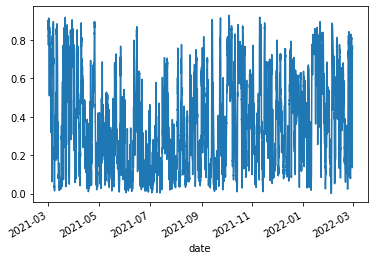

In [3]:
data['proportion'] = data.wind_power / data.wind_capacity

data.proportion.plot()
print(data)

<AxesSubplot:xlabel='date'>

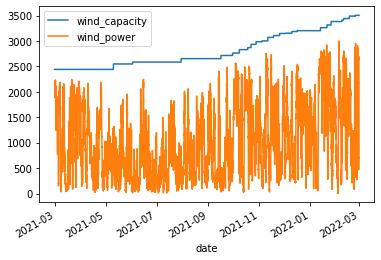

In [4]:
data.plot(y=['wind_capacity', 'wind_power'])

<AxesSubplot:xlabel='date'>

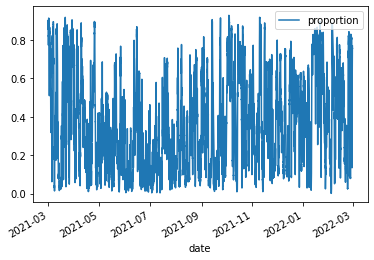

In [5]:
data.plot(y=['proportion'])

<AxesSubplot:xlabel='date'>

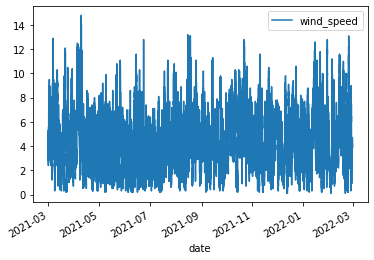

In [6]:
data.plot(y=['wind_speed'])

In [7]:
X = []
y = []

for index, row in data.iterrows():
    X.append([row.wind_speed])
    y.append(row.proportion)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=True)
print("Total set:", len(X))
print("Training set:", len(X_train))
print("Validation set:", len(X_val))
print("Testing set:", len(X_test))

Total set: 52538
Training set: 42030
Validation set: 5254
Testing set: 5254


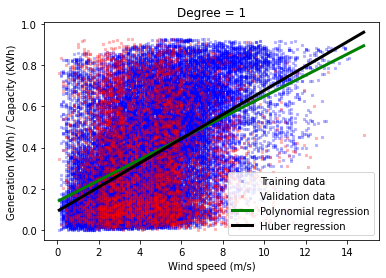

Degree 1
Training loss: Polynomial regression = 0.04867005765022077, Huber regression = 0.04914028124449266
Validation loss: Polynomial regression = 0.07258497688624796, Huber regression = 0.07654687384876825
Test loss: Polynomial regression = 0.05057003843850935, Huber regression = 0.051137962493388506


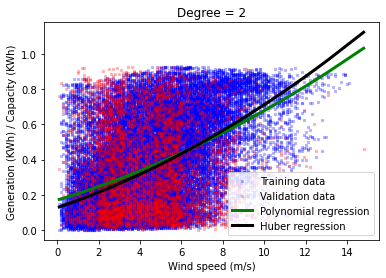

Degree 2
Training loss: Polynomial regression = 0.048564420535453234, Huber regression = 0.04907930921671546
Validation loss: Polynomial regression = 0.07275156315999154, Huber regression = 0.07680882041021958
Test loss: Polynomial regression = 0.05045897357169194, Huber regression = 0.051064212208203105


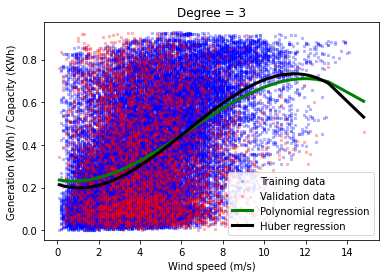

Degree 3
Training loss: Polynomial regression = 0.04833243683977122, Huber regression = 0.04894697134661386
Validation loss: Polynomial regression = 0.07321071666946254, Huber regression = 0.07805859197582868
Test loss: Polynomial regression = 0.05033076508966939, Huber regression = 0.05107278538243968


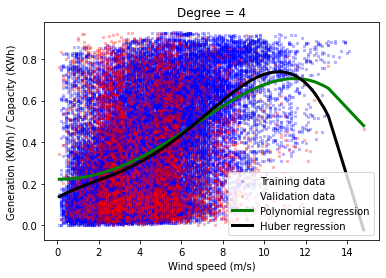

Degree 4
Training loss: Polynomial regression = 0.048326014415001006, Huber regression = 0.04902599189217653
Validation loss: Polynomial regression = 0.07320658169336507, Huber regression = 0.07799481377816041
Test loss: Polynomial regression = 0.05034452996399143, Huber regression = 0.051258108558495025


In [12]:
for degree in [1, 2, 3, 4]:

    from sklearn.preprocessing import PolynomialFeatures
    from sklearn import linear_model
    from sklearn.linear_model import HuberRegressor
    from sklearn.metrics import mean_squared_error

    poly = PolynomialFeatures(degree=degree)
    
    if degree == 1:
        X_train_poly = X_train
        X_val_poly = X_val
        X_test_poly = X_test
    else:
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        X_test_poly = poly.transform(X_test)
        

    clf = linear_model.LinearRegression().fit(X_train_poly, y_train)
    huber = HuberRegressor().fit(X_train_poly, y_train)

    y_train_pred = clf.predict(X_train_poly)
    y_val_pred = clf.predict(X_val_poly)
    y_test_pred = clf.predict(X_test_poly)
    
    y_train_huber_pred = huber.predict(X_train_poly)
    y_val_huber_pred = huber.predict(X_val_poly)
    y_test_huber_pred = huber.predict(X_test_poly)
    
    train_error = mean_squared_error(y_train, y_train_pred)
    val_error = mean_squared_error(y_val, y_val_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    train_huber_error = mean_squared_error(y_train, y_train_huber_pred)
    val_huber_error = mean_squared_error(y_val, y_val_huber_pred)
    test_huber_error = mean_squared_error(y_test, y_test_huber_pred)
    
    plt.scatter(X_train, y_train, color="blue", marker='x', s=6, alpha=0.3, label='Training data')
    plt.scatter(X_val, y_val, color="red", marker='x', s=6, alpha=0.3, label='Validation data')
    #plt.scatter(X_test, y_test, color="purple", marker='x', s=6, label='Test data')

    X_val, y_val_pred = zip(*sorted(zip(X_val, y_val_pred), key=operator.itemgetter(0)))
    X_val_huber, y_val_huber_pred = zip(*sorted(zip(X_val, y_val_huber_pred), key=operator.itemgetter(0)))

    plt.plot(X_val, y_val_pred, color="green", linewidth=3, label='Polynomial regression')
    plt.plot(X_val_huber, y_val_huber_pred, color="black", linewidth=3, label='Huber regression')
    
    plt.title("Degree = {}".format(degree))
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Generation (KWh) / Capacity (KWh)')
    plt.legend()
    plt.show()
    
    print("Degree {}".format(degree))
    print("Training loss: Polynomial regression = {}, Huber regression = {}".format(train_error, train_huber_error))
    print("Validation loss: Polynomial regression = {}, Huber regression = {}".format(val_error, val_huber_error))
    print("Test loss: Polynomial regression = {}, Huber regression = {}".format(test_error, test_huber_error))
    
